# Assignment 3: Data Migrations and Transformations

## Task I: Transformations with SQL during extract.

In [3]:
import os
import sqlite3
import pandas as pd

In [4]:
!wget -O customer_transformation_data.db https://github.com/matthewpecsok/data_engineering/raw/main/data/customer_transformations_data.db

--2024-09-12 03:03:13--  https://github.com/matthewpecsok/data_engineering/raw/main/data/customer_transformations_data.db
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthewpecsok/data_engineering/main/data/customer_transformations_data.db [following]
--2024-09-12 03:03:13--  https://raw.githubusercontent.com/matthewpecsok/data_engineering/main/data/customer_transformations_data.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57344 (56K) [application/octet-stream]
Saving to: ‘customer_transformation_data.db’

customer_transforma 100%[===================>]  56.00K  --.-KB/s    in 0.01s   


In [5]:
conn = sqlite3.connect("customer_transformation_data.db")

In [6]:
cur = conn.cursor()

In [7]:
# Query to get table names from sqlite_master
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(tables)

[('customers',), ('customer_emails',)]


In [8]:
# Getting the first few rows of the customers table to see the column names of the customers table
pd.read_sql_query("SELECT * FROM customers LIMIT 5;", conn)

,customerid,age,first_name,last_name,created_date
0,1,-37,Scott,Sims,2021-08-19
1,2,-46,Richard,Bennett,2021-09-17
2,3,48,Juan,Barber,2023-02-23
3,4,-35,Sarah,Bonilla,2021-08-07
4,5,-47,Leah,Faulkner,2021-08-19


In [9]:
# Getting the first few rows of the customer_emails table to see the column names of the customer_emails table
pd.read_sql_query("SELECT * FROM customer_emails LIMIT 5;", conn)

,customerid,email,email_type
0,1,allentracy@example.com,home
1,1,None,work
2,2,waterspatrick@example.org,home
3,2,monique81@example.org,work
4,3,lawrenceangela@example.net,home


In [10]:
# Using SQL to extract data from both table, left join them and identify and correct any errors in the age and email columns and saving it in a pandas dataframe

customers_sql_df = pd.read_sql("""SELECT
c.customerid,
c.first_name,
c.last_name,
abs(c.age) as age, -- Converting negative age to positive
c.created_date,
coalesce(ce.email, 'missing') as email, -- Replacing null values with missing
ce.email_type

FROM customers c
LEFT JOIN customer_emails ce
ON c.customerid = ce.customerid
WHERE c.created_date < '2023-01-01'
""",conn)

# Showing the first 7 rows of the migrated table

customers_sql_df.head(7)

,customerid,first_name,last_name,age,created_date,email,email_type
0,1,Scott,Sims,37,2021-08-19,missing,work
1,1,Scott,Sims,37,2021-08-19,allentracy@example.com,home
2,2,Richard,Bennett,46,2021-09-17,monique81@example.org,work
3,2,Richard,Bennett,46,2021-09-17,waterspatrick@example.org,home
4,4,Sarah,Bonilla,35,2021-08-07,amandasimpson@example.net,work
5,4,Sarah,Bonilla,35,2021-08-07,gmyers@example.net,home
6,5,Leah,Faulkner,47,2021-08-19,missing,work


In [11]:
# Checking to see if the previous query got rid of all the negative age values by calling all the rows that could be negative and taking the sum of the resulting dataframe

sum(customers_sql_df['age'] < 0)

0

Since the sum of the resulting dataframe is 0 that means all the rows had FALSE as the output for this condition (as any logical expression like this creates a series of TRUE or FALSE) and hence there is no negative age (or TRUE value in resulting series) in the age column now.

In [12]:
# Checking to see if the previous query replaced all the null values in the email column to 'missing'

customers_sql_df['email'].isna().sum()

0

Similarly, Since the sum of the resulting dataframe is 0 that means all the rows had FALSE as the output for this condition (as any logical expression like this creates a series of TRUE or FALSE) and hence there is no null email in the email column now.

## Task II: Transformations with Pandas.

In [13]:
# Extracting the customers table from the databse into a dataframe

customers_df = pd.read_sql_query("SELECT * FROM customers;", conn)

customers_df.head()

,customerid,age,first_name,last_name,created_date
0,1,-37,Scott,Sims,2021-08-19
1,2,-46,Richard,Bennett,2021-09-17
2,3,48,Juan,Barber,2023-02-23
3,4,-35,Sarah,Bonilla,2021-08-07
4,5,-47,Leah,Faulkner,2021-08-19


In [14]:
# Extracting the customer_emails table from the databse into a dataframe

customer_emails_df = pd.read_sql_query("SELECT * FROM customer_emails;", conn)

customer_emails_df.head()

,customerid,email,email_type
0,1,allentracy@example.com,home
1,1,None,work
2,2,waterspatrick@example.org,home
3,2,monique81@example.org,work
4,3,lawrenceangela@example.net,home


In [15]:
# Checking for values in age table from customers_df to get insights on the data contained in it

customers_df['age'].describe()

,age
count,1000.000000
mean,-1.112000
std,34.858809
min,-60.000000
25%,-31.250000
50%,-2.000000
75%,28.250000
max,60.000000


In [16]:
# Changing the values in age column to positive as that seems to be the only issue above

customers_df['age'] = abs(customers_df['age'])

customers_df['age'].describe()

,age
count,1000.000000
mean,30.174000
std,17.464041
min,0.000000
25%,16.000000
50%,30.000000
75%,45.000000
max,60.000000


In [17]:
# Checking for values in email table from customer_emails_df to get the frequency of null values in it

customer_emails_df['email'].isna().sum()

32

In [18]:
# Changing the null values in email table to 'missing'

customer_emails_df['email'] = customer_emails_df['email'].fillna('missing')

customer_emails_df['email'].isna().sum()

0

In [19]:
# Using Pandas to join the two dataframes into a single dataframe

customers_pd_df = pd.merge(customers_df,customer_emails_df, on='customerid')

customers_pd_df.head()

,customerid,age,first_name,last_name,created_date,email,email_type
0,1,37,Scott,Sims,2021-08-19,allentracy@example.com,home
1,1,37,Scott,Sims,2021-08-19,missing,work
2,2,46,Richard,Bennett,2021-09-17,waterspatrick@example.org,home
3,2,46,Richard,Bennett,2021-09-17,monique81@example.org,work
4,3,48,Juan,Barber,2023-02-23,lawrenceangela@example.net,home


In [20]:
# Filtering data to only include records with created_date less than 2023

customers_pd_df = customers_pd_df[customers_pd_df['created_date'] < '2023-01-01']

customers_pd_df.head()

,customerid,age,first_name,last_name,created_date,email,email_type
0,1,37,Scott,Sims,2021-08-19,allentracy@example.com,home
1,1,37,Scott,Sims,2021-08-19,missing,work
2,2,46,Richard,Bennett,2021-09-17,waterspatrick@example.org,home
3,2,46,Richard,Bennett,2021-09-17,monique81@example.org,work
6,4,35,Sarah,Bonilla,2021-08-07,gmyers@example.net,home


In [21]:
# Using pandas and sqlite to load the final transformed dataframe into a new migration table.

customers_pd_df.to_sql('customers_pd', conn, if_exists='replace', index=False)

# Showing the first 8 rows of the migrated table

pd.read_sql_query("SELECT * FROM customers_pd LIMIT 8;", conn)

,customerid,age,first_name,last_name,created_date,email,email_type
0,1,37,Scott,Sims,2021-08-19,allentracy@example.com,home
1,1,37,Scott,Sims,2021-08-19,missing,work
2,2,46,Richard,Bennett,2021-09-17,waterspatrick@example.org,home
3,2,46,Richard,Bennett,2021-09-17,monique81@example.org,work
4,4,35,Sarah,Bonilla,2021-08-07,gmyers@example.net,home
5,4,35,Sarah,Bonilla,2021-08-07,amandasimpson@example.net,work
6,5,47,Leah,Faulkner,2021-08-19,xharrison@example.org,home
7,5,47,Leah,Faulkner,2021-08-19,missing,work


In [22]:
# Proving that the new datframe has the issues with age and email resolved

pd.read_sql_query("SELECT * FROM customers_pd WHERE age < 0 OR email is null;", conn)

,customerid,age,first_name,last_name,created_date,email,email_type


It can be seen above that the query returns an empty dataframe which shows that there are no negative age and no email with null or na value

## Task III: Transformations with SQL on staging tables.

In [23]:
# Creating a new sqlite migration datbase

conn_new = sqlite3.connect("customer_new.db")

In [24]:
cur_new = conn_new.cursor()

In [25]:
# Loading the raw untransformed tables from source db to the new db

customers_df.to_sql('customers', conn_new, if_exists='replace', index=False)
customer_emails_df.to_sql('customer_emails', conn_new, if_exists='replace', index=False)

200

In [26]:
cur_new.execute("""drop table if  exists final_table """)
conn_new.commit()

In [27]:
# Creating a new table named final_table with the required columns
cur_new.execute("""create table if not exists final_table (
customerid,
first_name,
last_name,
age,
created_date,
email,
email_type
)"""
)
conn_new.commit()

In [28]:
cur_new.execute("""
delete from final_table
""")
conn_new.commit()

In [29]:
# Using the same SQL query but with INSERT as in task 1 to extract data from both table, left join them and identify and correct any errors in the age and email columns and inserting it into final table

cur_new.execute("""
INSERT INTO final_table
SELECT
c.customerid,
c.first_name,
c.last_name,
abs(c.age) as age, -- Converting negative age to positive
c.created_date,
coalesce(ce.email, 'missing') as email, -- Replacing null values with missing
ce.email_type

FROM customers c
LEFT JOIN customer_emails ce
ON c.customerid = ce.customerid
WHERE c.created_date < '2023-01-01'
""")
conn_new.commit()


In [30]:
# Writing a SQL query to show the first 3 rows in the final table

cur_new.execute("""
SELECT * FROM final_table LIMIT 3
""")
cur_new.fetchall()

[(1, 'Scott', 'Sims', 37, '2021-08-19', 'allentracy@example.com', 'home'),
 (1, 'Scott', 'Sims', 37, '2021-08-19', 'missing', 'work'),
 (2, 'Richard', 'Bennett', 46, '2021-09-17', 'monique81@example.org', 'work')]

In [31]:
# Proving that the final destination table has no issues in the age and email column

cur_new.execute("""
SELECT * FROM final_table WHERE age < 0 OR email is null
""")
cur_new.fetchall()

[]

## Task IV: Upload to Cloud Object storage

In [32]:
# Fetching the transformed data from the 'final_table' in the new database
final_df = pd.read_sql_query("SELECT * FROM final_table;", conn_new)

# Generating CSV and Parquet files
csv_file = 'customer_email_Ahmad_Ahsan.csv'
parquet_file = 'customer_email_Ahmad_Ahsan.parquet'

# Save as CSV
final_df.to_csv(csv_file, index=False)

# Save as Parquet
final_df.to_parquet(parquet_file, index=False)

In [33]:
# Checking the sizes of both files to see which one is smaller.

csv_size = os.path.getsize(csv_file)
parquet_size = os.path.getsize(parquet_file)

print(f"CSV File Size: {csv_size} bytes")
print(f"Parquet File Size: {parquet_size} bytes")

if csv_size < parquet_size:
    print("CSV file is smaller.")
elif csv_size > parquet_size:
    print("Parquet file is smaller.")

CSV File Size: 40806 bytes
Parquet File Size: 24198 bytes
Parquet file is smaller.


In [34]:
from google.colab import userdata
from google.cloud import storage

In [36]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/western-watch-434803-i1-04a900216c57.json"

In [37]:
GCP_PROJECT = 'de-object-assignment-fall2024'

In [38]:
STORAGE_BUCKET = 'customer-transformation-data-fall2024'

In [41]:
storage_client = storage.Client() # create the Client.
bucket = storage_client.bucket(STORAGE_BUCKET) # get the bucket instance
blob = bucket.blob('final_table_parquet') # create a new blob, give it a name (can be different that the local filename)

blob.upload_from_filename(parquet_file) # upload the local file named 'customers.csv'

print(f"File {parquet_file} uploaded to GCP bucket {STORAGE_BUCKET}.")

File customer_email_Ahmad_Ahsan.parquet uploaded to GCP bucket customer-transformation-data-fall2024.


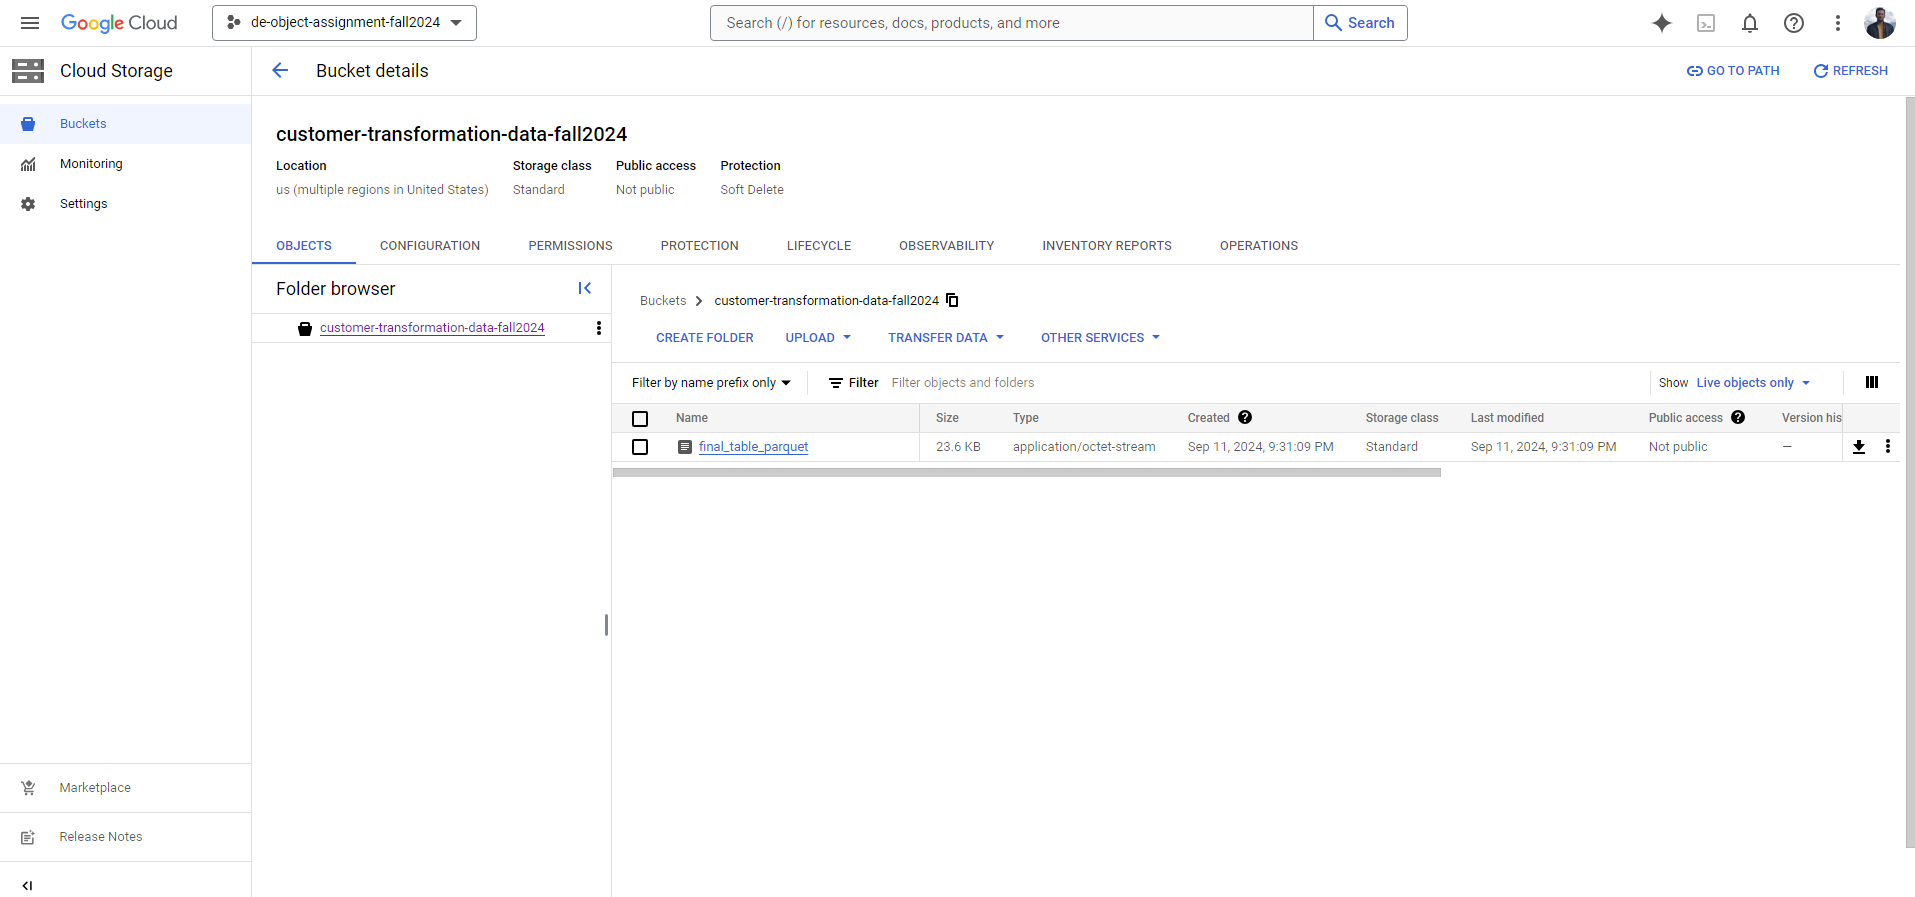

In [50]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/Colab Notebooks/de_lab_3_Ahmad_Ahsan.ipynb" ./
!jupyter nbconvert --to html "de_lab_3_Ahmad_Ahsan.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook de_lab_3_Ahmad_Ahsan.ipynb to html
[NbConvertApp] Writing 698298 bytes to de_lab_3_Ahmad_Ahsan.html
